# ReAct Agent with LangGraph

**LangChain**의 `create_agent`를 활용하여 **ReAct** 기반의 AI 에이전트를 구축하는 방법을 다룹니다. 계산기 툴 예제를 통해 에이전트의 핵심 구성 요소와 상태 관리 방법을 학습합니다.

**🏆 핵심 내용**

*   **ReAct Agent**: Reasoning and Acting 프레임워크의 개념 및 동작 원리
*   **Prebuilt Agent**: 메모리, Human-in-the-loop, 스트리밍, 배포 등 주요 기능
*   **Tool Integration**: 계산기 툴 정의 및 에이전트 연동 실습
*   **Internal Structure**: 그래프(Graph), 상태(State), 메시지(Message) 흐름 분석
*   **Custom State**: `AgentState` 확장 및 Reducer 함수 구현
*   **State Injection**: `InjectedState`를 활용한 툴 내 상태 접근
*   **Command**: 툴 실행 결과를 통한 동적 상태 업데이트

## 환경 설정

환경 변수는 프로젝트 실행에 필요한 중요한 설정 정보를 담고 있습니다. 

`dotenv` 패키지를 사용하면 환경 변수 파일(`.env`)을 손쉽게 관리할 수 있습니다. 

`dotenv`는 기본적으로 상위 디렉토리(`../.env`)에서 `.env` 파일을 찾으며, 해당 파일이 존재할 경우 그 안의 환경 변수를 현재 셸의 변수보다 우선하여 불러옵니다. 만약 `.env` 파일이 없다면, 현재 셸에 설정된 환경 변수가 그대로 사용됩니다.

이렇게 환경 변수를 미리 설정해두면, 이후 LangChain 및 LangGraph를 활용한 에이전트 개발 과정에서 API 키 등 민감한 정보를 안전하게 관리할 수 있습니다.

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Deep-Agent-Tutorial


## Prebuilt ReAct Agent 소개

![](./assets/agent_header.png)

이번 과정에서는 [Deep Agent](https://blog.langchain.com/deep-agents/)를 직접 구현해 봅니다. 

LangChain에서 제공하는 pre-built agent 추상화를 활용하면 복잡한 코드를 간결하게 작성할 수 있습니다. 

본 튜토리얼에서는 **Prebuilt ReAct Agent**의 주요 개념과 기능을 다룹니다.

**주요 학습 내용**
- ReAct Agent 개념 이해  
- Prebuilt Agent의 기능  
  - 다양한 툴을 활용한 에이전트 구축 방법
  - 내부 그래프, 상태(state), 메시지(message) 구조 분석
  - 툴을 통해 상태에 접근하고 수정하는 방법
  - **Hook** 및 구조화된 응답 처리 방식

이 단원을 통해 Prebuilt ReAct Agent의 구조와 동작 방식을 익히고, 실제로 툴과 상태를 활용하는 방법을 단계별로 학습할 수 있습니다. 

추가적인 내용은 [Deep Agent 공식 블로그](https://blog.langchain.com/deep-agents/)에서 확인할 수 있습니다.

### ReAct Agent란?

![](./assets/agent.png)

**ReAct (Reasoning and Acting)** 는 LLM의 추론(CoT)과 외부 툴 실행을 결합한 프레임워크입니다.

*   **구성 요소**: LLM, Tools, Prompt
*   **동작 루프**: 관찰(Observation) → 추론(Reasoning) → 행동(Action) → 관찰
*   **원리**: LLM이 컨텍스트를 분석하여 툴 호출 여부를 결정하고, 실행 결과를 바탕으로 다음 단계를 계획

## `create_agent`

- **도구 바인딩**: 도구 정의 및 에이전트에 연결
- **메모리 통합**: 단기(세션) 및 장기(영구) 메모리 지원
- **Human-in-the-loop**: 워크플로우 일시 정지, 승인, 수정, 개입 가능
- **스트리밍**: 토큰, 상태, 툴 출력의 실시간 스트리밍
- **배포 생태계**: LangGraph Platform, Studio, LangSmith 연동 지원

간단한 **계산기(calculator)** 툴을 정의하고 에이전트에 연결하여, 실제 동작 방식을 실습합니다.

에이전트가 사용할 도구를 정의 합니다. 도구는 `@tool` 데코레이터를 사용하여 정의합니다.

도구 정의시 docstring 은 LLM 에게 전달될 도구의 설명입니다.

In [2]:
from typing import Annotated, List, Literal, Union
from langchain_core.tools import tool


@tool
def calculator(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
) -> Union[int, float]:
    """Define a two-input calculator tool that returns precise answers.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.

    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    elif operation == "divide":
        result = a / b
    return result

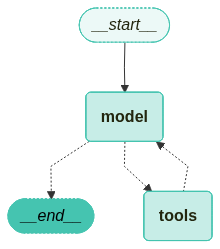

In [3]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from IPython.display import display
from langchain.chat_models import init_chat_model

from langchain.agents import create_agent
from utils import format_messages
from langchain_teddynote.graphs import visualize_graph

# 시스템 프롬프트 정의
SYSTEM_PROMPT = """You are a helpful arithmetic assistant who is an expert at using a calculator.
Return all text as plain text without Markdown math delimiters.
"""

# LLM 인스턴스 생성
model = init_chat_model(model="anthropic:claude-haiku-4-5", temperature=0.0)

# 도구 목록에 Tool 추가
tools = [calculator]

# ReAct Agent 생성
agent = create_agent(
    model,
    tools,
    system_prompt=SYSTEM_PROMPT,
).with_config(
    {"recursion_limit": 20}
)  # 에이전트 반복 실행 최대 횟수 제한

# 그래프 시각화
visualize_graph(agent)

In [4]:
# 생성된 Agent 의 타입 확인
type(agent)

langgraph.graph.state.CompiledStateGraph

## 에이전트 구조: Graph, State, Message

에이전트는 내부적으로 **LangGraph**를 통해 그래프 형태로 구성됩니다.

*   **AgentState**: 메시지 리스트(`messages`)를 포함하는 기본 상태 스키마
*   **ToolNode**: LLM이 요청한 툴을 실행하고 결과를 반환하는 노드
*   **Graph**: `create_agent`에 의해 자동 생성 및 컴파일되는 실행 흐름

에이전트를 실행하고 결과를 확인합니다.

In [5]:
from langchain_teddynote.messages import invoke_graph

inputs = {"messages": [{"role": "user", "content": "3.1 * 4.2 는 얼마입니까?"}]}

invoke_graph(agent, inputs)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

[{'text': '3.1 * 4.2를 계산하겠습니다.', 'type': 'text'}, {'id': 'toolu_016yYuL5e9jUoNeQnDJ7wMRx', 'input': {'operation': 'multiply', 'a': 3.1, 'b': 4.2}, 'name': 'calculator', 'type': 'tool_use'}]
Tool Calls:
  calculator (toolu_016yYuL5e9jUoNeQnDJ7wMRx)
 Call ID: toolu_016yYuL5e9jUoNeQnDJ7wMRx
  Args:
    operation: multiply
    a: 3.1
    b: 4.2

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: calculator

13.020000000000001

🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

3.1 * 4.2 = 13.02 입니다.


### 실행 시퀀스 분석

![에이전트 시퀀스 다이어그램](./assets/agent_sequence_diagram.png)

1.  **입력**: 사용자 질문 ("What is 3.1 * 4.2?")
2.  **추론 (LLM)**: `calculator` 툴 호출 결정 (`AIMessage` 생성)
3.  **실행 (ToolNode)**: 툴 실행 및 결과 반환 (`ToolMessage` 생성)
4.  **응답 (LLM)**: 툴 결과를 바탕으로 최종 답변 생성

### LangSmith 트레이스

LangSmith를 통해 에이전트의 내부 동작을 상세히 모니터링할 수 있습니다.

*   **확인 사항**: 툴 설명 전달, 인자 파싱, `tool_call_id` 매칭 여부
*   [트레이스 예시 보기](https://smith.langchain.com/public/e2c0f1ed-739b-43e0-8b35-b3062e1c2b17/r)

아래와 같이 invoke() 로 실행하면 결과를 return 받습니다.

In [6]:
# 질문
inputs = {"messages": [{"role": "user", "content": "3.1 * 4.2는 얼마입니까?"}]}
result = agent.invoke(inputs)

# 응답메시지 포맷팅
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 3.1 * 4.2는 얼마입니까?                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2를 계산하겠습니다.                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: toolu_017dxvDRytjqbS9YnFkMrJPi                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02입니다.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## AgentState

`from langchain.agents import AgentState` 는 LangGraph V1.0 에서 새롭게 추가된 클래스입니다.

이 AgentState 가 `create_agent` 에 기본으로 설정되어 있는 State 입니다.

LangGraph의 **State**는 노드 간 데이터 공유 및 영구 저장을 지원합니다.

*   **AgentState**: `messages` (메시지 목록)
*   **Reducer**: 상태 업데이트 로직 정의 (예: `add_messages`는 리스트에 메시지 추가)

In [7]:
from langchain_core.messages import messages_to_dict

messages_to_dict(result["messages"])

[{'type': 'human',
  'data': {'content': '3.1 * 4.2는 얼마입니까?',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '92fa530f-33a4-45eb-98d8-71a43c5c8515'}},
 {'type': 'ai',
  'data': {'content': [{'text': '3.1 * 4.2를 계산하겠습니다.', 'type': 'text'},
    {'id': 'toolu_017dxvDRytjqbS9YnFkMrJPi',
     'input': {'operation': 'multiply', 'a': 3.1, 'b': 4.2},
     'name': 'calculator',
     'type': 'tool_use'}],
   'additional_kwargs': {},
   'response_metadata': {'id': 'msg_011pb1Sx9LsP1H5TUrCjq4NZ',
    'model': 'claude-haiku-4-5-20251001',
    'stop_reason': 'tool_use',
    'stop_sequence': None,
    'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0,
      'ephemeral_5m_input_tokens': 0},
     'cache_creation_input_tokens': 0,
     'cache_read_input_tokens': 0,
     'input_tokens': 780,
     'output_tokens': 111,
     'server_tool_use': None,
     'service_tier': 'standard'},
    'model_name': 'claude-haiku-4-5-20251001',
    'model_pr

## Custom State 확장

만약 추가 키가 필요한 경우 `AgentState`를 확장하여 추가 키를 정의할 수 있습니다.

이번 예제에서는 연산 기록을 저장하는 `ops` 필드를 추가하고, 리스트 병합을 위한 `reduce_list` 함수를 구현합니다.

- **`CalcState`**: `ops` (연산 기록 리스트) 필드 추가
- **`reduce_list`**: 리스트 병합을 위한 Reducer 함수 구현

In [8]:
from langchain.agents import AgentState


# 리듀서: 두 리스트를 안전하게 병합하는 함수, None 입력 시 빈 리스트로 처리
def reduce_list(left: list | None, right: list | None) -> list:
    """두 리스트를 안전하게 병합, 입력값이 None일 경우 빈 리스트로 처리

    Args:
        left (list | None): 병합할 첫 번째 리스트 또는 None
        right (list | None): 병합할 두 번째 리스트 또는 None

    Returns:
        list: 두 입력 리스트의 모든 요소를 포함하는 새 리스트, None은 빈 리스트로 간주
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right


# ops 라는 연산 기록용 키를 추가합니다. 이때 reducer 를 사용하여 연산 값이 누적되도록 합니다.
class CalcState(AgentState):
    """그래프 상태 클래스"""

    ops: Annotated[List[str], reduce_list]

## State Injection (상태 주입)

LLM이 직접 생성할 수 없는 `state` 정보를 툴 실행 시점에 안전하게 주입합니다.

![](./assets/inject_state_diagram.png)

- **문제**: LLM은 현재 상태(`state`)를 인자로 전달할 수 없음
- **해결**: `Annotated[..., InjectedState]`를 사용하여 런타임에 상태 주입

아래와 같이 `InjectedState` 어노테이션을 활용하면, 툴 함수의 인자 중 `state`와 `tool_call_id`를 LLM에게 노출하지 않고 툴 실행 시점에 안전하게 주입할 수 있습니다.

```python
@tool
def calculator_wstate(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],         # ← LLM에 전달되지 않음
    tool_call_id: Annotated[str, InjectedToolCallId],   # ← LLM에 전달되지 않음
) -> Union[int, float]:
```

이 방식은 툴 설명에서 `state`와 같은 내부 정보를 자동으로 제거하여 LLM이 해당 인자를 인식하지 못하도록 처리합니다. 

(중요) 실제 툴 실행 단계에서는 `ToolNode`가 내부적으로 `state`와 `tool_call_id`를 주입하여, 툴 함수가 필요한 정보를 안전하게 사용할 수 있도록 합니다.  

**코드 예시**

```python
@tool
def calculator_wstate(
    ...,
    state: Annotated[CalcState, InjectedState],         # LLM에게 숨김, 런타임 주입
    tool_call_id: Annotated[str, InjectedToolCallId],   # LLM에게 숨김, 런타임 주입
):
```

*   **InjectedState**: 현재 에이전트의 상태 객체 주입
*   **InjectedToolCallId**: 현재 툴 호출의 고유 ID 주입

In [9]:
@tool
def calculator_wstate(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],  # not sent to LLM
    tool_call_id: Annotated[str, InjectedToolCallId],  # not sent to LLM
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.

    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    elif operation == "divide":
        result = a / b

    ops = [f"({operation}, {a}, {b}),"]
    return Command(
        update={
            "ops": ops,
            "messages": [ToolMessage(f"{result}", tool_call_id=tool_call_id)],
        }
    )

In [10]:
# 계산기 전문 도우미 역할을 명시하는 시스템 프롬프트 정의
SYSTEM_PROMPT = """
You are a helpful arithmetic assistant who is an expert at using a calculator.
Return all text as plain text without Markdown math delimiters.
"""

# LLM 객체 생성
model = init_chat_model(model="anthropic:claude-haiku-4-5", temperature=0.0)

# 연산 기록 기능이 포함된 calculator_wstate 툴을 툴 목록에 추가
tools = [calculator_wstate]  # new tool

# 커스텀 상태 스키마(CalcState)와 시스템 프롬프트를 적용하여 Prebuilt ReAct Agent 생성
agent = create_agent(
    model,
    tools,
    system_prompt=SYSTEM_PROMPT,
    state_schema=CalcState,  # now defining state scheme
).with_config(
    {"recursion_limit": 20}
)  # 에이전트 반복 실행 최대 횟수 제한 설정

In [11]:
# 에이전트에게 곱셈 질의 메시지 리스트 전달, 계산 요청 수행 및 결과 반환
result2 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "3.1 * 4.2는 얼마입니까?",
            }
        ],
    }
)

# 에이전트 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력, 메시지 구조 확인
format_messages(result2["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 3.1 * 4.2는 얼마입니까?                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2를 계산하겠습니다.                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: toolu_015LVR6bDoVgVTDUfLRoXuxs                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02입니다.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

이번에는 두 개의 툴 호출이 동시에 이루어지는 예시를 살펴보겠습니다. 이 경우, `tool node`는 각 툴 호출을 병렬로 실행하여 결과를 반환합니다.  

이처럼 복수의 툴 호출이 병렬로 처리되는 구조를 이해하면, 에이전트가 여러 작업을 효율적으로 수행하는 방식에 대해 더욱 깊이 있게 학습할 수 있습니다.

In [12]:
# 복수 연산 질의 메시지 리스트를 에이전트에게 전달하여 병렬 계산 요청 수행
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "3.1 * 4.2 + 5.5 * 6.5는 얼마입니까?",
            }
        ],
    }
)

# 에이전트의 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력
format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 3.1 * 4.2 + 5.5 * 6.5는 얼마입니까?                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 이 문제를 단계별로 계산하겠습니다.                                                                              │
│                                                                                                                 │
│ 먼저 3.1 * 4.2와 5.5 * 6.5를 각각 계산한 후, 두 결과를 더하겠습니다.                                            │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2                                                                                                      │
│ }                                                                                                               │
│    ID: toolu_01CANdjDssoJpN6JKkSkfinB                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 5.5,                                                                                                     │
│   "b": 6.5                                                                                                      │
│ }                                                                                                               │
│    ID: toolu_01FdAZzfTC8CFB2ZZ642XF6a                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 35.75                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 이제 두 결과를 더하겠습니다.                                                                                    │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 13.020000000000001,                                                                                      │
│   "b": 35.75                                                                                                    │
│ }                                                                                                               │
│    ID: toolu_01Rc9gtP7FMXtx3KDGYahpBF                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 48.77                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 답: 3.1 * 4.2 + 5.5 * 6.5 = 48.77                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
# 사용자에게 에이전트가 직접 예시를 생성하도록 질의 메시지 전달 및 결과 반환
result4 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "자신만의 예시를 만들어 보시겠습니까?",
            }
        ],
    }
)

# 에이전트의 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력
format_messages(result4["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 자신만의 예시를 만들어 보시겠습니까?                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 네, 기꺼이 예시를 만들어 드리겠습니다!                                                                          │
│                                                                                                                 │
│ 예를 들어, 다음과 같은 산술 문제를 풀어보겠습니다:                                                              │
│                                                                                                                 │
│ **문제: 한 학생이 책을 사러 가서 15,000원짜리 책 3권을 샀습니다. 그리고 5,000원짜리 펜 2개를 샀습니다. 총       │
│ 얼마를 썼을까요?**                                                                                              │
│                                                                                                                 │
│ 이 문제를 단계별로 풀어보겠습니다:                                                                              │
│                                                                                                                 │
│ 1단계: 책에 쓴 돈 계산 (15,000 × 3)                                                                             │
│ 2단계: 펜에 쓴 돈 계산 (5,000 × 2)                                                                              │
│ 3단계: 총액 계산 (책 비용 + 펜 비용)                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 15000,                                                                                                   │
│   "b": 3                                                                                                        │
│ }                                                                                                               │
│    ID: toolu_01GkLFqSaGq1scUkWJ55ra4P                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "a": 5000,                                                                                                    │
│   "b": 2                                                                                                        │
│ }                                                                                                               │
│    ID: toolu_01CiL7utndw5eA7NSiugaatZ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 45000                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 10000                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 이제 총액을 계산합니다:                                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "a": 45000,                                                                                                   │
│   "b": 10000                                                                                                    │
│ }                                                                                                               │
│    ID: toolu_01KHfiGnh2iMyxrXqUNApUfs                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 55000                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ **답: 학생은 총 55,000원을 썼습니다.**                                                                          │
│                                                                                                                 │
│ - 책 3권: 45,000원                                                                                              │
│ - 펜 2개: 10,000원                                                                                              │
│ - 총합: 55,000원                                                                                                │
│                                                                                                                 │
│ 이런 식으로 계산기를 사용하여 실생활의 산술 문제를 풀 수 있습니다!                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯